<a href="https://colab.research.google.com/github/GaikwadSandesh/Book_Recommendation_System/blob/main/Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import random 
import math

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Load data and Clean

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Loading Datasets
books=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Alma_better/Book Recommender system/Books.csv" )
ratings=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Alma_better/Book Recommender system/Ratings.csv")
users=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Alma_better/Book Recommender system/Users.csv")

## Handle nan

### Books

In [6]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [7]:
books = books[books['ISBN'].apply(lambda x: str(x).isdigit())]

In [8]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [9]:
# we won't be using any image processing s we will drop image related columns

books.drop(columns = ['Image-URL-S' , 'Image-URL-M' , 'Image-URL-L'] , inplace =True)

In [10]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [11]:
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1995, 1982, 1985, 1992, 1986, 1978, 1980, 1983, 1952,
       1987, 1981, 1990, 1989, 1984, 0, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1972, 1960, 1979, 1966,
       1920, 1973, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1950,
       1967, 2005, 1957, 1937, 1955, 1954, 1946, 1930, 2011, 1925, 1948,
       1943, 1947, 1923, 1939, 1926, 1938, 2030, 1940, 1911, 1949, 1932,
       1928, 1929, 1945, 1927, 1936, 1931, 1914, 2050, 1934, 1910, 1933,
       1902, 1924, 1921, 2038, 2026, 1944, 1917, 1901, 2010, 1908, 1906,
       1935, 1806, 2021, '2000', '1995', '1999', '2003', '1990', '1994',
       '1986', '1989', '2002', '1981', '1993', '1983', '1982', '1976',
       '1991', '1977', '1998', '1992', '0', '2001', '1997', '1996',
       '2004', '1968', '1987', '1984', '1988', '1963', '1956', '1974',
       '1970', '1985', '1978', '1973', '1980', '1979', '1961', 

In [12]:
#investigating the rows having 'DK Publishing Inc' as yearOfPublication
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [13]:
#From above, it is seen that bookAuthor is incorrectly loaded with bookTitle, hence making required corrections
#ISBN '0789466953'
books.loc[books.ISBN == '0789466953','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '0789466953','Book-Author'] = "James Buckley"
books.loc[books.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"
#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '078946697X','Book-Author'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [14]:
#investigating the rows having 'DK Publishing Inc' as yearOfPublication
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...


In [15]:
#making required corrections as above, keeping other fields intact
books.loc[books.ISBN == '2070426769','Year-Of-Publication'] = 2003
books.loc[books.ISBN == '2070426769','Book-Author'] = "Jean-Marie Gustave"
books.loc[books.ISBN == '2070426769','Publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','Book-Title'] = "Peuple du ciel, suivi de 'Les Bergers"

In [16]:
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [17]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249026 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 249026 non-null  object
 1   Book-Title           249026 non-null  object
 2   Book-Author          249025 non-null  object
 3   Year-Of-Publication  249026 non-null  int64 
 4   Publisher            249025 non-null  object
dtypes: int64(1), object(4)
memory usage: 11.4+ MB


In [18]:
#However, the value 0 is invalid and as this dataset was published in 2004, I have assumed the the years after 2006 to be 
#invalid keeping some margin in case dataset was updated thereafer
#setting invalid years as NaN
books.loc[(books['Year-Of-Publication']> 2006) | (books['Year-Of-Publication']==0 ),'Year-Of-Publication'] = np.NAN

In [19]:
books['Year-Of-Publication'].fillna(int(books['Year-Of-Publication'].median()) , inplace = True)

In [20]:
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

In [21]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              1
dtype: int64

In [22]:
#exploring 'publisher' column
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [23]:
#  we will google and replace missing value
books.loc[187689,'Book-Author'] = 'David Tait'

In [24]:
books.loc[books['Publisher'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [25]:
#  we will google and replace missing value
books.loc[128890,'Publisher'] = 'Mundania Press LLC'
books.loc[129037,'Publisher'] = 'Simon & Schuster.'

In [26]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249027 entries, 0 to 128890
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 249026 non-null  object 
 1   Book-Title           249026 non-null  object 
 2   Book-Author          249026 non-null  object 
 3   Year-Of-Publication  249026 non-null  float64
 4   Publisher            249027 non-null  object 
dtypes: float64(1), object(4)
memory usage: 19.5+ MB


In [27]:
books.isnull().sum()

ISBN                   1
Book-Title             1
Book-Author            1
Year-Of-Publication    1
Publisher              0
dtype: int64

### Rating

In [28]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [29]:
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

## User

In [30]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [31]:
users.isnull().sum()/len(users)*100

User-ID      0.000000
Location     0.000000
Age         39.719857
dtype: float64

In [32]:
users.Location.nunique()

57339

we can use Location to do the clustring based of location and recommend the books y popularity but in this case we will not use location

In [33]:
users.drop('Location',axis=1,inplace=True)

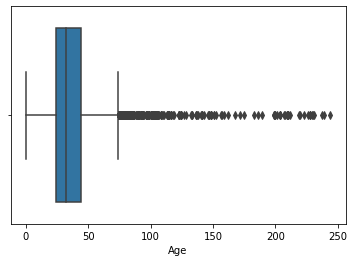

In [34]:
sns.boxplot(x = users.Age)

In [35]:
# outlier data became NaN
users.loc[(users.Age > 95) | (users.Age < 10), 'Age'] = np.nan

In [36]:
users.isna().sum()

User-ID         0
Age        112216
dtype: int64

In [37]:
users['Age'].fillna(users.Age.median(),inplace=True)

In [38]:
users.isna().sum()

User-ID    0
Age        0
dtype: int64

# EDA

## Books

### Top Authors

Text(0.5, 1.0, 'Top 10 Authors')

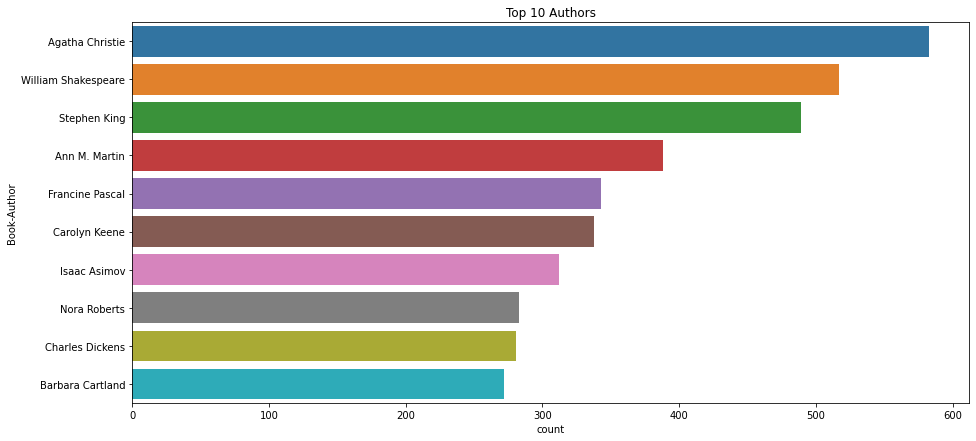

In [39]:
plt.figure(figsize=(15,7))
sns.countplot(y='Book-Author',data=books,order=pd.value_counts(books['Book-Author']).iloc[:10].index)
plt.title('Top 10 Authors')

### Top Publishers

Text(0.5, 1.0, 'Top 10 Publishers')

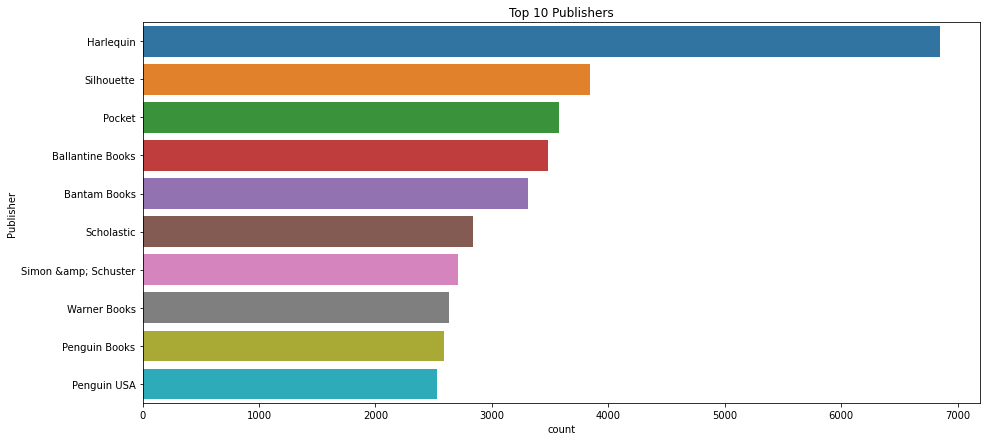

In [40]:
plt.figure(figsize=(15,7))
sns.countplot(y='Publisher',data=books,order=pd.value_counts(books['Publisher']).iloc[:10].index)
plt.title('Top 10 Publishers')

## Ratings

In [41]:
ratings.columns

Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

In [42]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [43]:
ratings['Book-Rating'].nunique()

11

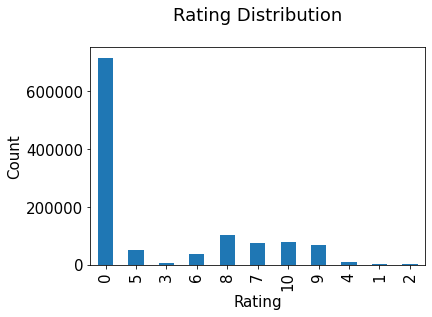

In [44]:
plt.rc("font", size=15)
ratings['Book-Rating'].value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [45]:
#Hence segragating implicit and explict ratings datasets
ratings_nonzero = ratings[ratings['Book-Rating'] != 0]
ratings_zero    = ratings[ratings['Book-Rating'] == 0]

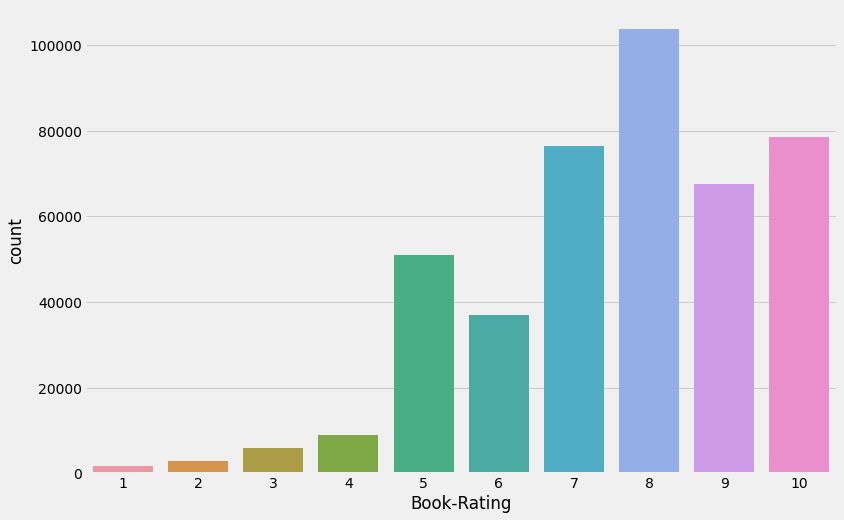

In [46]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings_nonzero , x='Book-Rating')

####  Total  Ratings and avg nuber of ratings

In [47]:
# Create column Rating average 
ratings_nonzero['Avg_Rating'] = ratings_nonzero.groupby('ISBN')['Book-Rating'].transform('mean')
# Create column Rating sum
ratings_nonzero['Total_No_Of_Users_Rated']= ratings_nonzero.groupby('ISBN')['Book-Rating'].transform('count')

# Merge all datasets

In [48]:
df=users.copy()
df=pd.merge(df,ratings_nonzero,on='User-ID')
df=pd.merge(df,books,on='ISBN')

In [49]:
df.head()

,User-ID,Age,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,8,32.0,0002005018,5,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
1,11676,32.0,0002005018,8,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,67544,30.0,0002005018,8,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
3,116866,32.0,0002005018,9,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
4,123629,32.0,0002005018,9,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada


In [50]:
df.shape

(352196, 10)

In [51]:
df.isnull().sum()

User-ID                    0
Age                        0
ISBN                       0
Book-Rating                0
Avg_Rating                 0
Total_No_Of_Users_Rated    0
Book-Title                 0
Book-Author                0
Year-Of-Publication        0
Publisher                  0
dtype: int64

# Popularity Based Recommendations  

**we will use weighted rating to guess the rating**
* We will only consider top 5 % books for this
* Weighted Rating(WR)=[vR/(v+m)]+[mC/(v+m)]
where,
v is the number of votes for the books;
m is the minimum votes required to be listed in the chart;
R is the average rating of the book; and
C is the mean vote across the whole report.
Now we find the values of v,m,R,C.

**This method is taken from internet**

In [52]:
C= df['Avg_Rating'].mean()
m= df['Total_No_Of_Users_Rated'].quantile(0.95)
Top_Books = df.loc[df['Total_No_Of_Users_Rated'] >= m]

In [53]:
Top_5per_books = df.loc[df['Total_No_Of_Users_Rated'] >= m]


In [54]:
def popularity_rating(data, m=m, C=C):
    v = data['Total_No_Of_Users_Rated']
    R = data['Avg_Rating']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [55]:
Top_5per_books['Popularity_rating'] = Top_5per_books.apply(popularity_rating,axis=1)

In [56]:
Top_5per_books.drop(columns=['User-ID' , 'Age', 'Book-Rating'], inplace = True)

In [57]:
Top_5per_books.drop_duplicates(inplace = True)

In [58]:
Top_5per_books.sort_values('Popularity_rating' , ascending= False , inplace = True , ignore_index =True)

In [59]:
Top_5per_books.head()

,ISBN,Avg_Rating,Total_No_Of_Users_Rated,Book-Title,Book-Author,Year-Of-Publication,Publisher,Popularity_rating
0,0439139597,9.262774,137,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000.0,Scholastic,8.509138
1,0446310786,8.943925,214,To Kill a Mockingbird,Harper Lee,1988.0,Little Brown &amp; Company,8.478312
2,0439136369,9.082707,133,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2001.0,Scholastic,8.401285
3,0439136350,9.035461,141,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999.0,Scholastic,8.396594
4,0439064872,8.783069,189,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000.0,Scholastic,8.340919


# Collabarative Filtering

we will consider only the user who have atleast five ratings

In [60]:
dataset = df[['User-ID' , 'ISBN' , 'Book-Rating']]

In [61]:
dataset.head()

,User-ID,ISBN,Book-Rating
0,8,0002005018,5
1,11676,0002005018,8
2,67544,0002005018,8
3,116866,0002005018,9
4,123629,0002005018,9


In [62]:
dataset['number_of_times_user_rated']= dataset.groupby('User-ID')['ISBN'].transform('count')

In [63]:
dataset.sort_values('number_of_times_user_rated' , ascending= False , inplace = True , ignore_index =True)

In [64]:
df2 = dataset[['User-ID' , 'ISBN' , 'number_of_times_user_rated']]

In [65]:
df2.drop_duplicates(inplace= True)

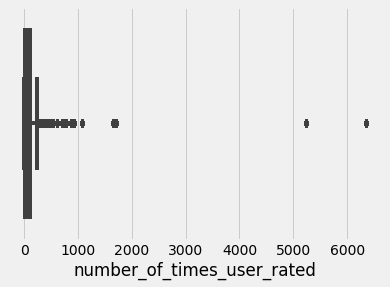

In [66]:
sns.boxplot(x = df2.number_of_times_user_rated)

* Some preople have voted extremly high number of time even one reads one book a week no one can read more than 3000 books.
These must be organisations so we will remove anyonw who have rated more than 500 books
* Also we will only consider people who have voted minimum 5 number of books


In [67]:
collb_df = dataset.loc[ (dataset['number_of_times_user_rated']>= 25) & (dataset['number_of_times_user_rated'] <= 100) ].drop(columns = 'number_of_times_user_rated')

In [68]:
collb_df.head()

,User-ID,ISBN,Book-Rating
88640,174892,0679425241,8
88641,15418,2203001143,10
88642,166596,0449216861,7
88643,15418,2203001178,10
88644,15418,0736647732,8


In [69]:
collb_df.shape

(92129, 3)

In [70]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = collb_df.groupby(['ISBN', 'User-ID'])['Book-Rating'].sum().apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head()

# of unique user/item interactions: 92129


,ISBN,User-ID,Book-Rating
0,0001048082,109901,3.169925
1,0001360469,10067,3.459432
2,0001374362,266866,3.321928
3,0001374869,10067,3.459432
4,0001714600,52853,3.169925


In [71]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['User-ID'], 
                                   test_size=0.3,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 64490
# interactions on Test set: 27639


In [72]:
interactions_test_df.head()

,ISBN,User-ID,Book-Rating
56285,0671019929,267033,3.000000
66329,0743457943,252865,2.807355
44595,0451625951,169682,2.584963
78806,0933598173,36554,3.459432
10332,0307100286,23288,3.459432


In [73]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='User-ID', 
                                                          columns='ISBN', 
                                                          values='Book-Rating').fillna(0)

users_items_pivot_matrix_df.head()

ISBN,0001048082,0001374869,0001821326,0001941941,0001941968,0001945203,0002005018,0002006588,0002116286,0002153572,...,9838120200,9838120634,9839995006,9879789970,9963842801,9971400162,9971401169,9976100248,9976100256,9990371628
User-ID,,,,,,,,,,,,,,,,,,,,,
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
users_items_pivot_matrix_df.shape

(2006, 40189)

In [75]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [76]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[254, 507, 638, 643, 651, 882, 1025, 1211, 1424, 1435]

In [77]:
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [78]:
users_items_pivot_matrix.shape

(2006, 40189)

In [79]:
U.shape

(2006, 15)

In [80]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [81]:
Vt.shape

(15, 40189)

In [82]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 8.71112103e-02, -3.12589350e-05, -1.17320630e-03, ...,
        -3.17156798e-03, -3.17156798e-03,  1.90772721e-02],
       [ 3.30113220e-03, -1.21950505e-05,  2.39819541e-03, ...,
         5.56628723e-03,  5.56628723e-03, -4.13250647e-03],
       [-1.26692722e-02, -8.70217768e-06,  1.54426826e-04, ...,
        -3.87601639e-03, -3.87601639e-03,  1.39048530e-02],
       ...,
       [-6.26140378e-03,  1.20769658e-05,  2.27479233e-04, ...,
        -1.93842977e-03, -1.93842977e-03,  4.42585037e-03],
       [-8.67093118e-03,  6.66984873e-06,  1.51848931e-04, ...,
        -2.76235109e-03, -2.76235109e-03,  7.53801943e-04],
       [ 4.94033056e-03, -1.44256168e-06,  5.09958951e-04, ...,
         2.08645668e-03,  2.08645668e-03,  6.59023951e-05]])

In [83]:
all_user_predicted_ratings.shape

(2006, 40189)

In [84]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head()

,254,507,638,643,651,882,1025,1211,1424,1435,...,277478,277639,277965,278026,278137,278188,278356,278418,278582,278633
ISBN,,,,,,,,,,,,,,,,,,,,,
0001048082,0.087111,0.003301,-0.012669,-0.001552,0.000398,0.001059,-0.004672,-0.001527,0.019657,0.004408,...,-0.000495,0.005799,-0.010028,-0.007203,-0.029798,-0.003916,0.014156,-0.006261,-0.008671,0.004940
0001374869,-0.000031,-0.000012,-0.000009,0.000002,0.000001,0.000005,-0.000014,-0.000004,0.000004,0.000001,...,0.000002,0.000009,-0.000004,0.000013,0.000008,0.000015,-0.000015,0.000012,0.000007,-0.000001
0001821326,-0.001173,0.002398,0.000154,0.000050,0.000004,0.000067,-0.000915,0.000647,0.001099,0.000364,...,0.000098,-0.000739,0.001026,0.000267,-0.000823,0.000196,-0.001103,0.000227,0.000152,0.000510
0001941941,-0.007829,-0.001791,-0.000549,0.000325,-0.000057,0.000161,0.000586,-0.001770,0.004830,0.002155,...,-0.000323,-0.000276,-0.004783,-0.001205,0.000935,0.000402,-0.007043,-0.000684,0.001108,0.001707
0001941968,-0.007829,-0.001791,-0.000549,0.000325,-0.000057,0.000161,0.000586,-0.001770,0.004830,0.002155,...,-0.000323,-0.000276,-0.004783,-0.001205,0.000935,0.000402,-0.007043,-0.000684,0.001108,0.001707


In [85]:
len(cf_preds_df.columns)

2006

In [86]:
global books
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company


In [87]:
def get_items_interacted(UserID, interactions_df):
    interacted_items = interactions_df.loc[UserID]['ISBN']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [88]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df):
        self.cf_predictions_df = cf_predictions_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating content that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['ISBN'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)
        recommendations_df=recommendations_df.merge(books,on='ISBN',how='inner')
        recommendations_df=recommendations_df[['ISBN','Book-Title','recStrength']]

        return recommendations_df



cf_recommender_model = CFRecommender(cf_preds_df)

In [94]:
interactions_full_indexed_df = interactions_full_df.set_index('User-ID')
interactions_train_indexed_df = interactions_train_df.set_index('User-ID')
interactions_test_indexed_df = interactions_test_df.iloc[:10000].set_index('User-ID')

In [95]:
class ModelRecommender:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, UserID, sample_size, seed=42):
        interacted_items = get_items_interacted(UserID, interactions_full_indexed_df)
        all_items = set(ratings_explicit['ISBN'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        
        if type(interacted_values_testset['ISBN']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['ISBN'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['ISBN'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df),topn=10000000000)
        print('Recommendation for User-ID = ',person_id)
        print(person_recs_df.head(10))

        # Function to evaluate the performance of model at overall level
    def recommend_book(self, model ,userid):
        
        person_metrics = self.evaluate_model_for_user(model, userid)  
        return

model_recommender = ModelRecommender()    

In [91]:
# user=int(input("Enter User ID from above list for book recommendation  "))
# model_recommender.recommend_book(cf_recommender_model,user)

In [96]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, UserID, sample_size, seed=42):
        interacted_items = get_items_interacted(UserID, interactions_full_indexed_df)
        all_items = set(collb_df['ISBN'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        
        if type(interacted_values_testset['ISBN']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['ISBN'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['ISBN'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df),topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            
            # Getting a random sample of 100 items the user has not interacted with
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=item_id)    #%(2**32))

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['ISBN'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['ISBN'].values
            
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    
    # Function to evaluate the performance of model at overall level
    def evaluate_model(self, model):
        
        people_metrics = []
        
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):    
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['User-ID'] = person_id
            people_metrics.append(person_metrics)
            
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

In [97]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1984 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.196, 'recall@10': 0.2573}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,User-ID
287,0,1,17,0.000000,0.058824,123608
448,4,4,17,0.235294,0.235294,174892
159,2,2,15,0.133333,0.133333,27169
1037,1,3,15,0.066667,0.200000,95010
1472,6,7,14,0.428571,0.500000,136348
620,4,4,14,0.285714,0.285714,146113
282,0,1,14,0.000000,0.071429,211919
118,5,5,14,0.357143,0.357143,102967
575,0,2,14,0.000000,0.142857,70666
296,1,2,13,0.076923,0.153846,179734
